In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from keras.models import load_model
import cv2
import numpy as np

In [10]:
model = load_model(os.path.join('models','cat_dog_classifier.h5'))

In [112]:
test_data = os.listdir('./test_data')

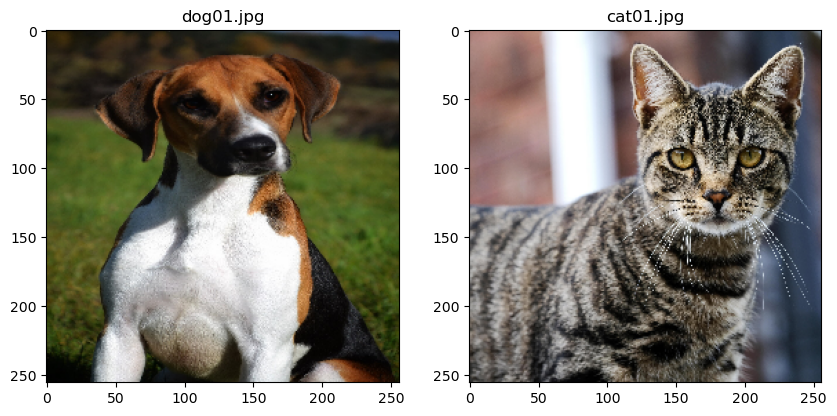

In [113]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
for idx, img in enumerate(test_data):
    img = cv2.imread(os.path.join('test_data', img))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
    resize_img = tf.image.resize(img_rgb, (256, 256))
    ax[idx].imshow(resize_img.numpy().astype(int))
    ax[idx].title.set_text(test_data[idx])

In [114]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [115]:
# 創建一個模型，包括原始模型的所有層
# 這個新模型將用於生成Grad-CAM熱圖
# 取得最後一層卷積層
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('conv2d_2').output, model.output])

In [178]:
# 加載測試圖像，你可以替換成你自己的圖像
img = cv2.imread(os.path.join('test_data', 'cat01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
resize_img = tf.image.resize(img_rgb, (256, 256))
img = np.expand_dims(resize_img / 255, 0)  # 將圖像轉換為模型期望的形狀
img.shape

(1, 256, 256, 3)

In [179]:
# 獲取模型的預測類別
preds = model.predict(img)
print(preds)
if preds < 0.5:
    class_idx = 0

1/1 [==============================] - 0s 15ms/step
[[0.00013507]]


In [180]:
# 計算梯度
with tf.GradientTape() as tape:
    last_conv_layer_output, model_output = grad_model(img)
    class_output = model_output[:, class_idx]
    grads = tape.gradient(class_output, last_conv_layer_output)

In [181]:
# 進行全局平均池化，獲取每個通道的權重
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [182]:
# 將權重乘以特徵圖的輸出，獲得特徵圖的Grad-CAM權重
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] # 矩陣乘法
print(heatmap.shape)
heatmap = tf.squeeze(heatmap)
print(heatmap.shape)

(60, 60, 1)
(60, 60)


In [183]:
# 對熱圖進行後處理，使其可視化
heatmap = tf.maximum(heatmap, 0)  # 移除負數值
heatmap /= tf.reduce_max(heatmap)  # 正規化
heatmap = heatmap.numpy()

In [184]:
# 使用OpenCV將熱圖映射到原始圖像
img = cv2.imread(os.path.join('test_data', 'cat01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
# resize_img = tf.image.resize(img_rgb, (256, 256))
resize_img = cv2.resize(img_rgb, (256, 256))
print(resize_img.shape)
print(img.shape)
# plt.imshow(resize_img.numpy().astype(int))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

(256, 256, 3)
(1800, 1800, 3)


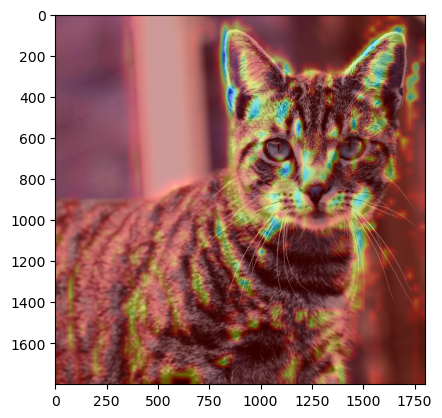

In [185]:
import matplotlib.pyplot as plt

# 假設你已經生成了Grad-CAM可視化的superimposed_img

# 顯示Grad-CAM可視化結果
plt.imshow(superimposed_img)
plt.show()

In [177]:
# 保存Grad-CAM可視化結果
cv2.imwrite('grad_cam_dog01.jpg', superimposed_img)

True